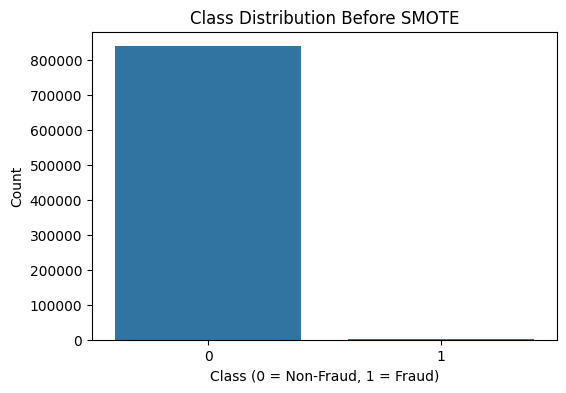

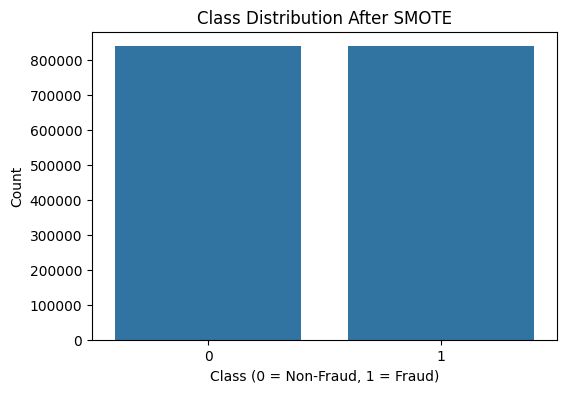

/tmp/ipython-input-2426867519.py:119: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


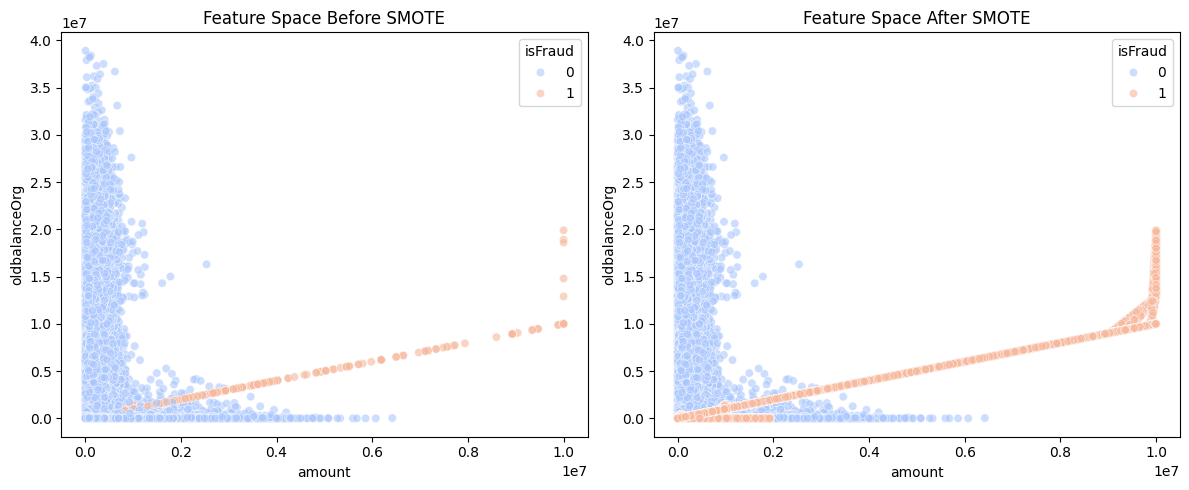


=== Training Random Forest ===
CV Recall: 0.9998


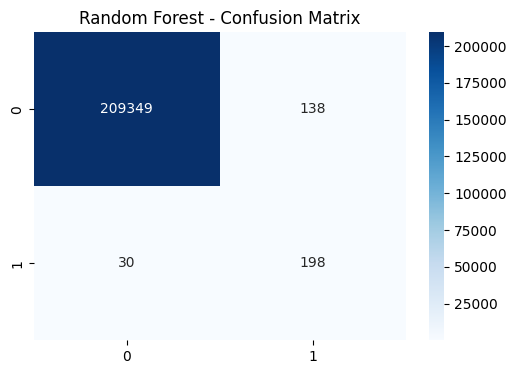


=== Training XGBoost ===
CV Recall: 1.0000


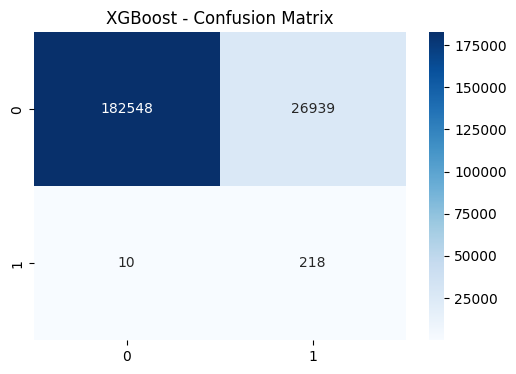


=== Training LightGBM ===
[LightGBM] [Info] Number of positive: 837946, number of negative: 837946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.313118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 1675892, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 558631, number of negative: 558630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 1117261, number of used features: 17
[LightGBM] [Info] [binary:BoostFromSco

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 558630, number of negative: 558631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 1117261, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 558631, number of negative: 558631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 1117262, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CV Recall: 0.9992


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


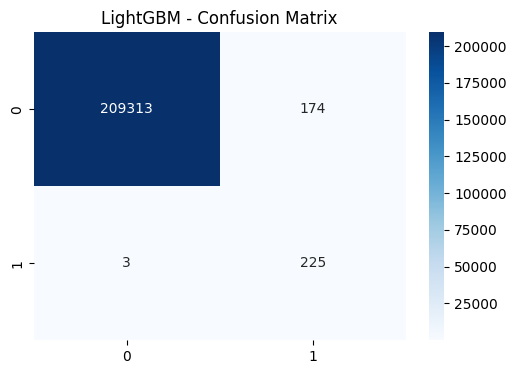


=== Model Comparison ===
               Accuracy  Precision    Recall  F1-score   ROC-AUC  \
Random Forest  0.999199   0.589286  0.868421  0.702128  0.994976   
XGBoost        0.871497   0.008027  0.956140  0.015921  0.894921   
LightGBM       0.999156   0.563910  0.986842  0.717703  0.998182   

               Average Precision  
Random Forest           0.856120  
XGBoost                 0.005698  
LightGBM                0.986103  


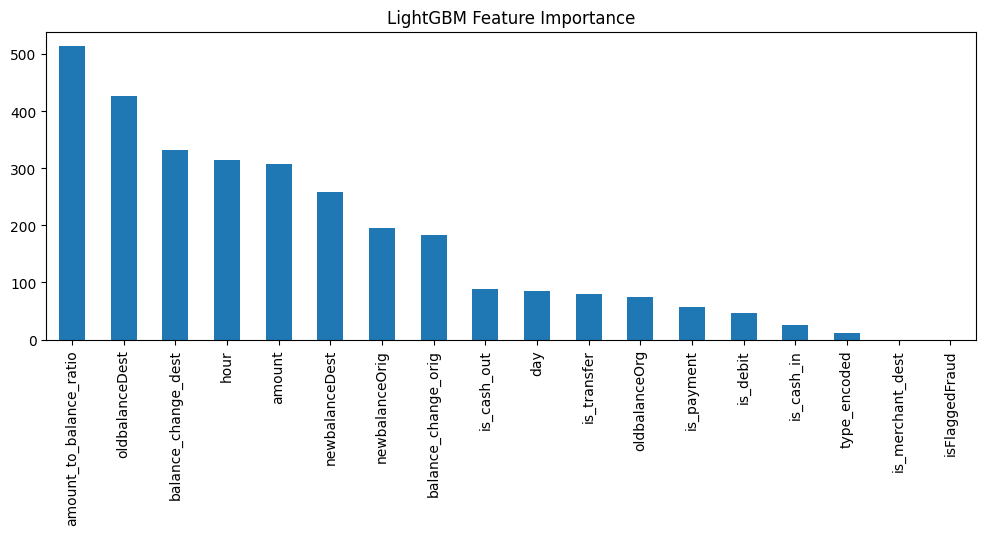

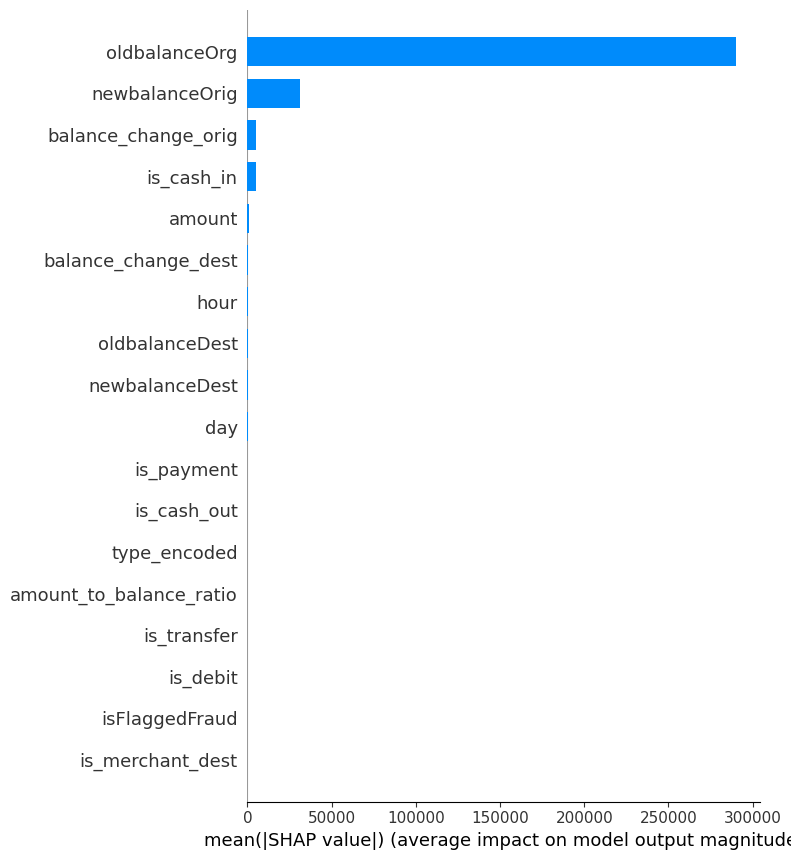

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             average_precision_score)
from imblearn.over_sampling import SMOTE
import shap
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# --- Data Loading ---
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')
df.dropna(inplace=True)

# --- Feature Engineering ---
# Time features
df['day'] = df['step'] // 24
df['hour'] = df['step'] % 24

# Transaction type flags
df['is_transfer'] = (df['type'] == 'TRANSFER').astype(int)
df['is_cash_out'] = (df['type'] == 'CASH_OUT').astype(int)
df['is_cash_in'] = (df['type'] == 'CASH_IN').astype(int)
df['is_debit'] = (df['type'] == 'DEBIT').astype(int)
df['is_payment'] = (df['type'] == 'PAYMENT').astype(int)

# Balance changes
df['balance_change_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_dest'] = df['oldbalanceDest'] - df['newbalanceDest']

# Amount ratio
df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1e-6)

# Merchant detection
df['is_merchant_dest'] = df['nameDest'].str.startswith('M').astype(int)

# Encode transaction type
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Keep isFlaggedFraud as a feature
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype(int)

# --- Select Features ---
features = [
    'day', 'hour',
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
    'balance_change_orig', 'balance_change_dest',
    'amount_to_balance_ratio',
    'is_transfer', 'is_cash_out', 'is_cash_in', 'is_debit', 'is_payment',
    'is_merchant_dest', 'isFlaggedFraud',
    'type_encoded'
]
X = df[features]
y = df['isFraud']

# --- Train-Test Split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Handle Imbalance (SMOTE) ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Handle Imbalance (SMOTE) ---
# Class distribution before SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# --- Visualizing Feature Space Expansion ---
# We'll take two numeric features for visualization
feature_x = 'amount'
feature_y = 'oldbalanceOrg'

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.scatterplot(
    x=X_train[feature_x],
    y=X_train[feature_y],
    hue=y_train,
    palette='coolwarm',
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_title("Feature Space Before SMOTE")

# After SMOTE
sns.scatterplot(
    x=X_train_res[feature_x],
    y=X_train_res[feature_y],
    hue=y_train_res,
    palette='coolwarm',
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_title("Feature Space After SMOTE")

plt.tight_layout()
plt.show()


# --- Standardization ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)

# --- Model Definitions ---
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

# --- Model Training & Evaluation ---
results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train_scaled, y_train_res)

    # Cross-Validation
    cv = StratifiedKFold(n_splits=3)
    cv_recall = cross_val_score(model, X_train_scaled, y_train_res, cv=cv, scoring='recall')
    print(f"CV Recall: {np.mean(cv_recall):.4f}")

    # Predictions
    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-score': f1_score(y_val, y_pred),
        'ROC-AUC': roc_auc_score(y_val, y_proba),
        'Average Precision': average_precision_score(y_val, y_proba)
    }
    results[name] = metrics

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='g', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

# --- Comparative Results ---
print("\n=== Model Comparison ===")
results_df = pd.DataFrame(results).T
print(results_df)

# --- Feature Importance (LightGBM) ---
lgb_model = models["LightGBM"]
feature_importance = pd.Series(lgb_model.feature_importances_, index=features)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 4))
plt.title("LightGBM Feature Importance")
plt.show()

# --- SHAP Explanations (XGBoost) ---
xg_model = models["XGBoost"]
explainer = shap.TreeExplainer(xg_model)
shap_values = explainer.shap_values(X_val_scaled)
shap.summary_plot(shap_values, X_val_scaled, feature_names=features, plot_type='bar')
